# ИМПОРТ БИБЛИОТЕК

In [13]:
from __future__ import print_function
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import os
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

# ГИПЕРПАРАМЕТРЫ СЕТИ

In [2]:
batch_size = 32  # Стандартный размер бачи
num_classes = 10  # Кол-во классов
epochs = 100
data_augmentation = False

# ЗАГРУЗКА ДАТАСЕТА

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print()
print()
print( 'Обучающая выборка', x_train.shape[0])
print('Тестовая выборка', x_test.shape[0])

170508288/170498071 [==============================] - 4s 0us/step


50000 тренировочные примеры
10000 тестовые примеры


# ПРИВЕДЕНИЕ ДАННЫХ

In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# СНС

In [9]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(batch_size * 3, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(batch_size * 3, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(batch_size * 2, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(batch_size * 2, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Классификатор софтмакс
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 96)        83040     
                                                                 
 activation_1 (Activation)   (None, 30, 30, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 96)        0         
                                                        

# ТРЕНИРОВКА МОДЕЛИ

In [11]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
gpus = tf.config.list_physical_devices('GPU') # Из Туториала по гпу тензорфлоу
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e) # мы попали сюда значит все ок 

Virtual devices cannot be modified after being initialized


In [16]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:2'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e) # Второй этап проверки пройден все ок двигаемся дальше

In [17]:
history = None  # записываем историю обучения

with tf.device('/device:GPU:2'):

    if not data_augmentation:
        print('Не используется data augmentation')
        history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True)
    else:
        print('Использование data augmentation в реальном времени')
        # Аугментация в реальном времени 
        datagen = ImageDataGenerator(
            featurewise_center=False,  # установить входное среднее значение 0 по набору данных
            samplewise_center=False,  # установите для каждого образца среднее значение 0
            featurewise_std_normalization=False,  # разделить входные данные на стандартное отклонение всей выборки
            samplewise_std_normalization=False,  # разделить входные данные на стандартное отклонение по батче
            zca_whitening=False,  # применить отбеливание ZCA
            zca_epsilon=1e-06,  # эпсилон для отбеливания ZCA
            rotation_range=0,  # произвольно поворачивать изображения в диапазоне (градусов, от 0 до 180)
            # произвольно сдвигать изображения по горизонтали (часть общей ширины)
            width_shift_range=0.1,
            # произвольно сдвигать изображения по вертикали (часть общей высоты)
            height_shift_range=0.1,
            shear_range=0.,  #установить диапазон для случайного сдвига
            zoom_range=0.,  # установить диапазон для случайного увеличения
            channel_shift_range=0.,  # установить диапазон для случайных сдвигов каналов
            # установить режим заливки точек за пределами входных границ
            fill_mode='nearest',
            cval=0.,  #значение, используемое для fill_mode = "constant"
            horizontal_flip=True,  # случайное переворачивание изображений по горизонтали
            vertical_flip=False,  # случайное переворачивание изображений по вертикали
            # установить коэффициент масштабирования (применяется перед любым другим преобразованием)
            rescale=None,
            # установить функцию, которая будет применяться к каждому входу
            preprocessing_function=None,
            # формат данных изображения, либо "каналы_фирне", либо "каналы_последний"
            data_format=None,
            # доля изображений, зарезервированных для проверки (строго от 0 до 1)
            validation_split=0.0)

        # Вычислить количества, необходимые для поэлементной нормализации
        # (стандартное, среднее и основные компоненты, если применяется отбеливание ZCA).
        datagen.fit(x_train)

        # Подгоните модель к пакетам, созданным с помощью datagen.flow ().
        history = model.fit_generator(datagen.flow(x_train, y_train,
                                        batch_size=batch_size),
                                        epochs=epochs,
                                        validation_data=(x_test, y_test),
                                        workers=4)

Не используется data augmentation
Epoch 1/100
1563/1563 [==============================] - 20s 8ms/step - loss: 1.7695 - accuracy: 0.3507 - val_loss: 1.5044 - val_accuracy: 0.4595
Epoch 2/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4095 - accuracy: 0.4914 - val_loss: 1.2743 - val_accuracy: 0.5335
Epoch 3/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2422 - accuracy: 0.5581 - val_loss: 1.1136 - val_accuracy: 0.6052
Epoch 4/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1230 - accuracy: 0.6038 - val_loss: 1.2035 - val_accuracy: 0.5765
Epoch 5/100
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0370 - accuracy: 0.6356 - val_loss: 0.9826 - val_accuracy: 0.6576
Epoch 6/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9749 - accuracy: 0.6593 - val_loss: 0.9445 - val_accuracy: 0.6727
Epoch 7/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9238 - acc

# РАБОТАСПОСОБНОСТЬ

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


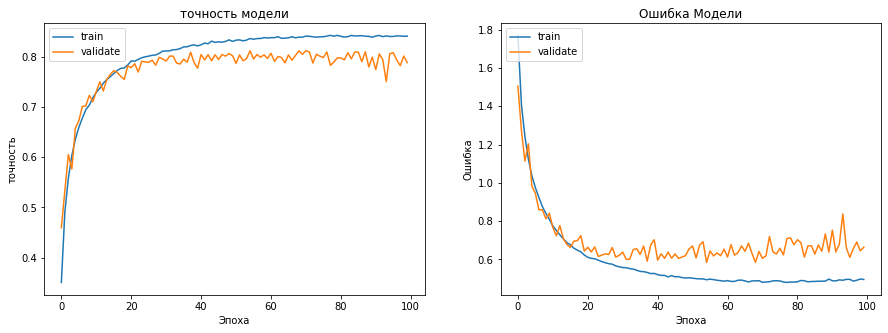

In [19]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # Изменение точность по эпохам
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('точность модели')
    axs[0].set_ylabel('точность') 
    axs[0].set_xlabel('Эпоха')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # Измененние ошибки по эпохам
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Ошибка Модели')
    axs[1].set_ylabel('Ошибка') 
    axs[1].set_xlabel('Эпоха')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

# ОЦЕНКА МОДЕЛИ

In [23]:
# Оценка модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Ошибка на тестовых данных:', scores[0])
print('Точность на тестовых данных:', scores[1])

# Пердсказание модели
pred = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.6639 - accuracy: 0.7882
Ошибка на тестовых данных: 0.6638538837432861
Точность на тестовых данных: 0.7882000207901001


In [20]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [21]:
labels=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

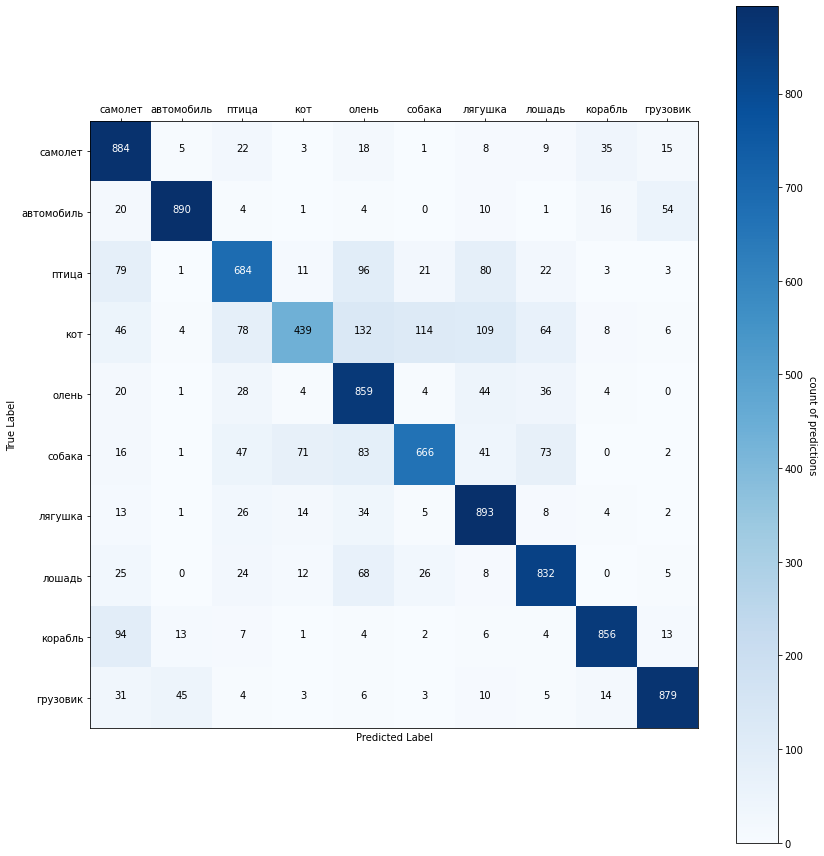

In [24]:
# переводим предсказание к векторному типу  one hot
Y_pred_classes = np.argmax(pred, axis=1) 
# переводим валидационные данные к векторному типу  one hot
Y_true = np.argmax(y_test, axis=1)

# разнциа между предсказаным вектором и валидационным
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

# Больше всего нас подвели КОТИКИ

In [25]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1000
           1       0.93      0.89      0.91      1000
           2       0.74      0.68      0.71      1000
           3       0.79      0.44      0.56      1000
           4       0.66      0.86      0.75      1000
           5       0.79      0.67      0.72      1000
           6       0.74      0.89      0.81      1000
           7       0.79      0.83      0.81      1000
           8       0.91      0.86      0.88      1000
           9       0.90      0.88      0.89      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.78     10000
weighted avg       0.80      0.79      0.78     10000



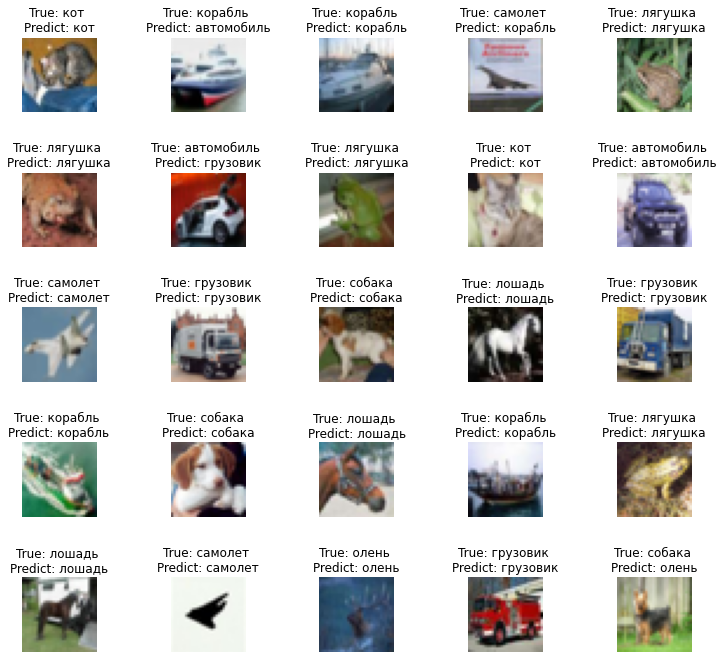

In [26]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)